In [1]:
# from numba import jit
import numpy as np
import matplotlib.pyplot as plt
from types import SimpleNamespace
import time
from copy import deepcopy


In [14]:
# Configure the system's initial conditions
def conf_ini(N, boxsize, temper):
    L = int(
        np.sqrt(N)
    )  # Define a dimensao linear da rede quadrada  (Atencao!!! A raiz quadrada de N é suposta inteira)

    x = np.zeros(N)
    y = np.zeros(N)

    vx = np.zeros(N)
    vy = np.zeros(N)

    cont = 0
    for i in range(L):
        for j in range(L):
            # distribui as partículas numa rede quadrada centrada
            x[cont] = (i + 0.5) - L / 2
            y[cont] = (j + 0.5) - L / 2

            # Escolhe a velocidade uniformemente num circulo unitario
            phi = np.random.uniform(0, 2 * np.pi)
            vx[cont] = np.cos(phi)
            vy[cont] = np.sin(phi)

            cont += 1

    # normaliza as posições para dentro da caixa
    x = x / L * boxsize
    y = y / L * boxsize

    # normaliza as velocidades de acordo com o teorema da equiparticao da energia
    prov = np.sqrt((2.0 - 2.0 / N) * temper)

    vx = vx * prov
    vy = vy * prov

    # Zera o momento total das partículas
    prov = np.sum(vx)
    vx = vx - prov / N
    prov = np.sum(vy)
    vy = vy - prov / N

    return SimpleNamespace(**{"x": x, "y": y, "vx": vx, "vy": vy})


# Add random perturbation to the positions
def perturbate(state, part_size, amount, boxsize):
    new_state = deepcopy(state)
    for i in range(N):
        phi = np.random.uniform(0, 2 * np.pi)
        new_state.x[i] = calc_coord(
            new_state.x[i] + np.cos(phi) * part_size * amount, boxsize
        )
        new_state.y[i] = calc_coord(
            new_state.y[i] + np.sin(phi) * part_size * amount, boxsize
        )

    return new_state


# Calculate the distance between particles i and j
def calc_dist(i, j, state, boxsize):
    x = state.x
    y = state.y
    xij = x[i] - x[j]  # Distancia entre as partículas
    yij = y[i] - y[j]

    xij = calc_coord(xij, boxsize)  # aplica condicoes de contorno periódicas
    yij = calc_coord(yij, boxsize)

    r2 = xij**2 + yij**2

    return r2, xij, yij


# Create the verlet list
def verlet_list(
    state, rv, boxsize
):  # Cria uma lista de Verlet para definir os vizinhos
    x = state.x
    y = state.y

    N = len(x)  # numero de particulas

    nviz = np.zeros(N, np.int64)  # declara os arrays
    viz = np.empty(0, np.int64)

    cont = 0  # contador do numero de vizinhos (indice do array viz)

    for i in range(N):  # loop sobre todas as partículas
        for j in range(i + 1, N):  # loop sobre todos os possiveis vizinhos

            r2, *_ = calc_dist(i, j, state, boxsize)

            if r2 < rv:
                cont += 1
                nviz[i] = cont
                viz = np.append(viz, [j])

    return nviz, viz


# Calculate the potential at a distance r
def lennard_jones_pot(r, depth, part_size):
    return 4 * depth * ((part_size / r) ** (12) - (part_size / r ** (6)))


# Calculate the force at a distance r
def lennard_jones_force(r, depth, part_size):
    return 48 * depth * (part_size ** (12) / r ** (14) - part_size ** (6) / r ** (8))


# Apply periodic boundary conditions
def calc_coord(dist, boxsize):
    return dist - boxsize * np.rint(dist / boxsize)


# Velocity-verlet position step
def position_step(rt, vt, at, dt, boxsize):
    r_step = rt + dt * vt + dt**2 * at / 2

    return calc_coord(r_step, boxsize)


# Velocity-verlet velocity step
def velocity_step(vt, at, a_step, dt):
    return vt + dt * (at + a_step) / 2


def time_step(state, dt, boxsize):
    # TODO: atualizar a lista de verlet apenas quando: Na*2*vmax*dt < rv - rc
    # vmax = np.amax(state.vx**2 + state.vy**2)
    
    
    nviz, viz = verlet_list(state, rv, boxsize)

    state.ax = np.zeros(N)
    state.ay = np.zeros(N)

    state.pot = np.zeros(N)

    for i in range(N):
        nviz_i = nviz[i]
        viz_i = viz[nviz[i - 1] : nviz_i]

        axi = state.ax[i]
        ayi = state.ay[i]

        poti = state.pot[i]

        for j in viz_i:
            r2, xij, yij = calc_dist(i, j, state, boxsize)

            # if r2 < 0.0077 * part_size:
            #     raise Exception("Position threshold reached")

            apply_potential = r2 < rcut

            if apply_potential:
                potential = lennard_jones_pot(np.sqrt(r2), depth, part_size)
                force = lennard_jones_force(np.sqrt(r2), depth, part_size)
                
                print(i, j, f'r2: {r2}', f'v: {state.vx[i]}', f'force: {force}')

                r_ang = np.arccos(xij**2 / r2)

                axi += (
                    0
                    if xij == 0
                    else xij * force * np.cos(r_ang) / mass
                )
                ayi += (
                    0
                    if yij == 0
                    else yij * force * np.sin(r_ang) / mass
                )

                poti += potential / mass

            state.pot[j] += poti
            state.ax[j] -= axi
            state.ay[j] -= ayi

        state.x[i] = position_step(state.x[i], state.vx[i], state.ax[i], dt, boxsize)
        state.y[i] = position_step(state.y[i], state.vy[i], state.ay[i], dt, boxsize)

        state.vx[i] = velocity_step(state.vx[i], state.ax[i], axi, dt)
        state.vy[i] = velocity_step(state.vy[i], state.ay[i], ayi, dt)

        state.ax[i] += axi
        state.ay[i] += ayi

        state.pot[i] += poti


def calc_pos_deviation(ref_state, pert_state):
    sum = 0
    for i in range(N):
        pert_pos = np.sqrt(pert_state.x[i] ** 2 + pert_state.y[i] ** 2)
        ref_pos = np.sqrt(ref_state.x[i] ** 2 + ref_state.y[i] ** 2)

        sum += (pert_pos - ref_pos) ** 2

    avg_deviation = sum / N

    return avg_deviation


def calc_energy(state):
    kin_energy = 0
    pot_energy = 0

    for i in range(N):
        v2 = state.vx[i] ** 2 + state.vy[i] ** 2
        kin_energy += mass * v2 / 2

        pot_energy += state.pot[i]

    return kin_energy, pot_energy


def plot_dev_over_time(dev_over_time):
    fig, ax = plt.subplots(1, 1)

    ax.set_yscale("log")
    ax.plot(dev_over_time)

    
def aux(state):
    nviz, viz = verlet_list(ref_state, rv, boxsize)
    plt.scatter(ref_state.x, ref_state.y)
    plt.show()

    for i in range(N):
        nviz_i = nviz[i]
        viz_i = viz[nviz[i - 1] : nviz_i]

        print(i, viz_i)

In [15]:
L = 2
N = L * L
mass = 1

# densidade
rho = 0.06
# dimensao linear da caixa
boxsize = np.sqrt(N / rho)

temper = 1.05

# Raio de corte Lennard-Jones
rcut = 2
rcut = rcut**2

# Raio para lista de verlet
rv = 5
rv = rv**2

# Parameters of the lennard-jones potential
# (https://www.researchgate.net/figure/Lennard-Jones-parameters-for-argon-and-carbon-atoms_tbl1_348928432)
depth = 1# 10.3 * 10 ** (-3)
part_size = 1# 3.405 * 10 ** (-10)

dt = 0.005

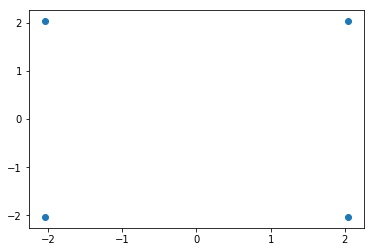

0 [1 2]
1 [3]
2 [3]
3 []


In [18]:
ref_state = conf_ini(N, boxsize, temper)
aux(ref_state)


In [20]:
pert_state = perturbate(ref_state, part_size, 10 ** (-3), boxsize)
iterations = 1000

i = 0
# st = time.time()

dev_over_time = np.array([])
kin_energy_over_time = np.array([])
pot_energy_over_time = np.array([])

try:
    while i < iterations:
        i += 1
        time_step(ref_state, dt, boxsize)
        time_step(pert_state, dt, boxsize)

        deviation = calc_pos_deviation(ref_state, pert_state)
        dev_over_time = np.append(dev_over_time, deviation)

        kin_energy, pot_energy = calc_energy(ref_state)
        kin_energy_over_time = np.append(kin_energy_over_time, kin_energy)
        pot_energy_over_time = np.append(pot_energy_over_time, pot_energy)
except:
    print("Number of iterations:", i)

print("Number of iterations:", i)

# et = time.time()
# get the execution time
# elapsed_time = et - st
# print('Execution time:', elapsed_time, 'seconds')


0 1 r2: 2.9740093083680983 v: 0.023200905586492772 force: -0.5902548047316716
0 1 r2: 2.971776666084838 v: 0.023200905586492772 force: -0.5919778242972369
0 1 r2: 2.9355357560137136 v: 0.02328570452344557 force: -0.620833420869528
0 1 r2: 2.933338761178966 v: 0.023286608440886473 force: -0.6226378348476379
0 1 r2: 2.897285032221766 v: 0.023377421131727104 force: -0.6531933500659602
0 1 r2: 2.8951234953560987 v: 0.02337929813827084 force: -0.6550832954812693
0 1 r2: 2.85925475267564 v: 0.023476651110298872 force: -0.6874507104205732
0 1 r2: 2.8571284838428133 v: 0.023479575964943544 force: -0.6894305444564479
0 1 r2: 2.8214424484916716 v: 0.02358404468651809 force: -0.7237300374851057
0 1 r2: 2.8193512574094735 v: 0.02358809821382694 force: -0.7258043488302458
0 1 r2: 2.7838455632926626 v: 0.023700311947365986 force: -0.7621649525316705
0 1 r2: 2.7817892594560316 v: 0.023705581559080858 force: -0.7643385731080679
0 1 r2: 2.746461450216058 v: 0.02382622872804978 force: -0.802898886771667

0 1 r2: 1.7898941573429852 v: -0.8637070565946977 force: -3.8610688582052655
0 1 r2: 1.790222539804475 v: -0.8632480106739738 force: -3.8586850567744677
0 1 r2: 1.8277587756642326 v: -0.8520616370233179 force: -3.596579828169527
0 1 r2: 1.8280928304827566 v: -0.8515766842940632 force: -3.59433746998735
0 1 r2: 1.8657304372810266 v: -0.8410390898665681 force: -3.3514155764359637
0 1 r2: 1.8660709306044065 v: -0.8405302612665135 force: -3.3493037600927487
0 1 r2: 1.9038192359018105 v: -0.8306072005307604 force: -3.1242520869102535
0 1 r2: 1.904166965439245 v: -0.8300763883167002 force: -3.1222603863080955
0 1 r2: 1.9420350758115061 v: -0.8207345848615913 force: -2.9138024316378206
0 1 r2: 1.942390871175496 v: -0.8201835508410594 force: -2.91192103423943
0 1 r2: 1.9803876296337226 v: -0.8113909200015798 force: -2.718835247778979
0 1 r2: 1.9807523524447328 v: -0.8108213035777865 force: -2.7170550264355025
0 1 r2: 2.0188863083303685 v: -0.8025470926256725 force: -2.5381855162348286
0 1 r2: 

1 3 r2: 3.6043860004828527 v: -0.10141299831719497 force: -0.2783178746962898
0 3 r2: 3.688078965352222 v: -0.652616589163583 force: -0.25427028860176615
1 3 r2: 3.6998385708179256 v: -0.10528081208309965 force: -0.25110150242249507
0 3 r2: 3.7212933962889023 v: -0.6533151725427542 force: -0.24544555499666543
1 3 r2: 3.6870425004116227 v: -0.10011123618078753 force: -0.2545519533334354
0 3 r2: 3.6532402077146067 v: -0.6526603200292397 force: -0.26395405342098793
1 3 r2: 3.7841963040340127 v: -0.10408103886860594 force: -0.229751037948142
0 3 r2: 3.6888246880316093 v: -0.6533557119404351 force: -0.25406787397326125
1 3 r2: 3.770621105831403 v: -0.09890603739486963 force: -0.23303009916028566
0 3 r2: 3.6195897076426062 v: -0.6527009587833177 force: -0.27374601167997026
1 3 r2: 3.8695009943915366 v: -0.10297020199366258 force: -0.2104069688987527
0 3 r2: 3.657539910937552 v: -0.6533932085244724 force: -0.26273442995267415
1 3 r2: 3.8551248421421658 v: -0.09778940131635841 force: -0.213520

0 3 r2: 2.9480823123612647 v: -0.6598863958511175 force: -0.6106513928586567
1 3 r2: 2.5275346779473877 v: -0.18902993096375406 force: -1.1032844435828724
0 3 r2: 3.68303581269996 v: -0.6527247350069274 force: -0.25564444222175947
1 3 r2: 1.3440360030230571 v: -0.1791310671170481 force: -8.650993093404006
0 3 r2: 2.8501894209844414 v: -0.661317537376623 force: -0.6959407156339283
1 3 r2: 2.61191752269228 v: -0.18897590152083032 force: -0.9734641221531914
0 3 r2: 3.6275016093479477 v: -0.6532372636795172 force: -0.27140372308240934
1 3 r2: 1.3403416333613665 v: -0.17855312236486193 force: -8.695975451309232
0 3 r2: 2.7539678812296966 v: -0.6629131152027831 force: -0.7945093056999089
1 3 r2: 2.6981708000587927 v: -0.18892034184205556 force: -0.8595506934524306
0 3 r2: 3.5739563989936913 v: -0.6537606601090448 force: -0.28775645523897053
1 3 r2: 1.3371111210899005 v: -0.17783858837512193 force: -8.735009274878735
0 3 r2: 2.6594001091580566 v: -0.6646941437948275 force: -0.9086141851620786

0 2 r2: 0.7970055499040773 v: 1.5706107251991597 force: 116.0110732053223
1 3 r2: 1.061786584076228 v: 0.7316982680922156 force: -6.216607619476944
2 3 r2: 2.908002399743441 v: -1.0441110866301808 force: -0.6439211631529009
0 1 r2: 3.7315303641316677 v: -0.6692675443762677 force: -0.24280265632518055
2 3 r2: 3.8713662625407297 v: -1.018456422680505 force: -0.21000708456082426
0 2 r2: 0.7587781675201294 v: 1.5714744528943616 force: 186.6603709573379
1 3 r2: 1.0521237920179016 v: 0.7455088486054909 force: -5.5382315590737505
2 3 r2: 2.8791027028143175 v: -1.047810752329216 force: -0.6693030657091213
0 1 r2: 3.7021829902775747 v: -0.6695015892200182 force: -0.2504756411739515
2 3 r2: 3.8765452337255413 v: -1.0183914999178085 force: -0.20890173638766701
0 2 r2: 0.7297014184928134 v: 1.5734070051940419 force: 266.4360953064094
1 3 r2: 1.0434152483050463 v: 0.7574580068616416 force: -4.847559395625968
2 3 r2: 2.8473149614138644 v: -1.0537609799808776 force: -0.6986596536296932
0 1 r2: 3.6729

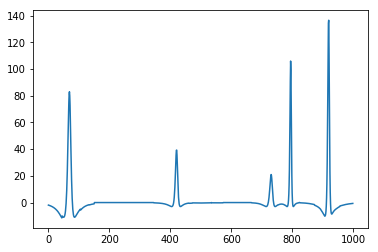

In [24]:
fig, ax = plt.subplots(1, 1)

# ax.plot(kin_energy_over_time)

# plt.show()

ax.plot(pot_energy_over_time)
plt.show()
